In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



C:\Users\xia\AppData\Local\Temp\ipykernel_18084\2869826499.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\xia\AppData\Local\Temp\ipykernel_18084\2869826499.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [2]:
def getData(filename, remove_duplicata = True):
    with open(filename) as f:
        df = pd.read_csv(f)
        if remove_duplicata:
            df = df.drop_duplicates()
        X = df.to_numpy()
    return X[:,:-1], X[:,-1]


In [ ]:
def getData2(filename1,filename2, remove_duplicata = True):
    df1 = pd.read_csv(filename1)
    df1.drop(df1.columns[len(df1.columns)-1], axis=1,inplace = True)
    df2 = pd.read_csv(filename2)
    X1 = df1.to_numpy()
    X2 = df2.to_numpy()
    s1, s2 = X1.shape[1], X2.shape[1]
    X11, X12 = X1[:,s1//2:], X1[:,:s1//2]
    X21, X22 = X2[:,s1//2:], X2[:,:s1//2]
    X = np.hstack((X11,X21,X12,X22))
    return X[:,:-1], X[:,-1]

In [3]:
X, Y = getData("../data/dataSelection2.csv")
np.unique(Y)

array(['CTRL + Left', 'CTRL + Right', 'CTRL + Shift + Left',
       'CTRL + Shift + Right', 'CTRL+ A (SelectAll)', 'Fin (End)', 'Home',
       'Shift + End', 'Shift + Home'], dtype=object)

In [4]:

le = preprocessing.LabelEncoder()

tmp = X[:,X.shape[1]//2:]
anotherX = X[:,:X.shape[1]//2]-tmp
anotherX = anotherX.astype('int64')
#anotherX = normalize(anotherX)
le.fit(Y)
Ynum = le.transform(Y)

In [5]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(anotherX),torch.Tensor(Ynum).type(torch.LongTensor))
dataset[1]

(tensor([0., 0., 0., 0., 0.]), tensor(5))

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_tanH_stack = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(np.unique(Y)))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_tanH_stack(x)
        return logits


In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
epochs = 100

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


# Create the data loaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=200,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=200,
    shuffle=False
)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.090386  [  200/ 8274]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.023128 

Epoch 2
-------------------------------
loss: 1.003535  [  200/ 8274]
Test Error: 
 Accuracy: 67.7%, Avg loss: 0.827970 

Epoch 3
-------------------------------
loss: 0.676299  [  200/ 8274]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.664115 

Epoch 4
-------------------------------
loss: 0.606094  [  200/ 8274]
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.584335 

Epoch 5
-------------------------------
loss: 0.555493  [  200/ 8274]
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.546995 

Epoch 6
-------------------------------
loss: 0.494637  [  200/ 8274]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.535912 

Epoch 7
-------------------------------
loss: 0.455527  [  200/ 8274]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.493569 

Epoch 8
-------------------------------
loss: 0.461063  [  200/ 8274]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.503883 

Epoch 9
----------------

Test Error: 
 Accuracy: 83.6%, Avg loss: 0.393457 

Epoch 69
-------------------------------
loss: 0.334037  [  200/ 8274]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.371796 

Epoch 70
-------------------------------
loss: 0.252412  [  200/ 8274]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.368264 

Epoch 71
-------------------------------
loss: 0.307807  [  200/ 8274]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.370516 

Epoch 72
-------------------------------
loss: 0.334327  [  200/ 8274]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.349906 

Epoch 73
-------------------------------
loss: 0.347795  [  200/ 8274]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.371780 

Epoch 74
-------------------------------
loss: 0.357665  [  200/ 8274]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.411556 

Epoch 75
-------------------------------
loss: 0.361836  [  200/ 8274]
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.390601 

Epoch 76
-------------------------------
loss: 0.300323  [  200/ 8274]
Test Error: 
 Ac

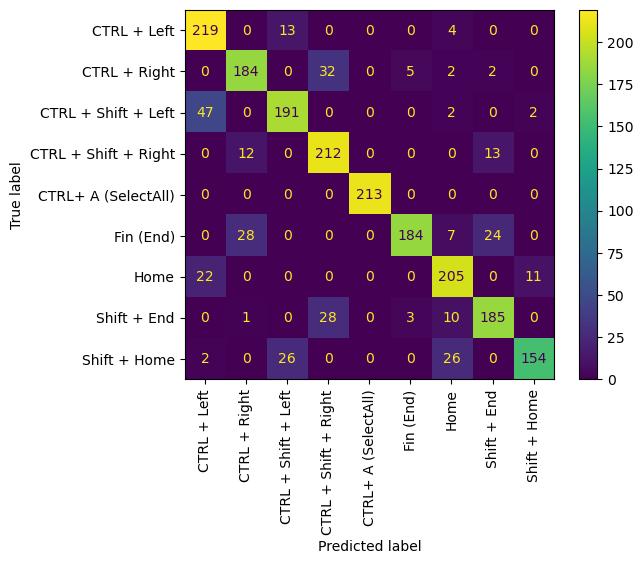

In [19]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []
predictions = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    predictions.extend(pred.tolist())
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot()
plt.xticks(rotation=90)
plt.show()

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

In [20]:


prec = np.round(precision_score(y_true, y_pred, average=None), 3)
rap = np.round(recall_score(y_true, y_pred, average=None), 3)
FPR = FP/(FP+TN)
print("Precision :",dict(zip(le.classes_, prec)))
print("\n")
print("Rappel :", dict(zip(le.classes_, rap)))
print("\n")
#print("FPR : ",dict(zip(le.classes_, FP/conf_matrix.sum(axis=0))))
print("FPR : ",dict(zip(le.classes_, FPR)))
print("\n")
print("ROC AUC SCORE :",roc_auc_score(y_true, predictions, multi_class='ovr'))

Precision : {'CTRL + Left': 0.755, 'CTRL + Right': 0.818, 'CTRL + Shift + Left': 0.83, 'CTRL + Shift + Right': 0.779, 'CTRL+ A (SelectAll)': 1.0, 'Fin (End)': 0.958, 'Home': 0.801, 'Shift + End': 0.826, 'Shift + Home': 0.922}


Rappel : {'CTRL + Left': 0.928, 'CTRL + Right': 0.818, 'CTRL + Shift + Left': 0.789, 'CTRL + Shift + Right': 0.895, 'CTRL+ A (SelectAll)': 1.0, 'Fin (End)': 0.757, 'Home': 0.861, 'Shift + End': 0.815, 'Shift + Home': 0.74}


FPR :  {'CTRL + Left': 0.03873431533006001, 'CTRL + Right': 0.022234273318872018, 'CTRL + Shift + Left': 0.021346469622331693, 'CTRL + Shift + Right': 0.03275109170305677, 'CTRL+ A (SelectAll)': 0.0, 'Fin (End)': 0.004381161007667032, 'Home': 0.02785363189513927, 'Shift + End': 0.021172638436482084, 'Shift + Home': 0.006985491671144546}


ROC AUC SCORE : 0.9890880308866754


Accuracy avant:  0.8443692605123247
Accuracy après:  0.951048951048951
pred restantes:  1573
pred supprimees:  496
pourcentage restant:  0.7602706621556308


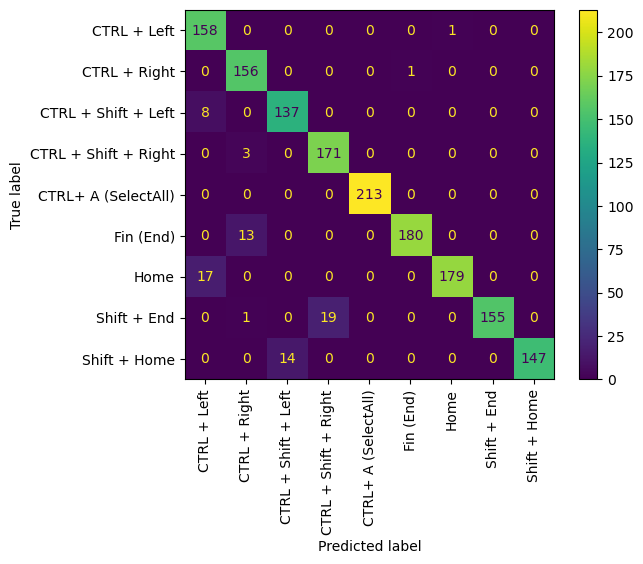

In [23]:
#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.75
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=90)

plt.show()

In [25]:
torch.save(model.state_dict(), "../models/modelSel")

In [43]:
loading = torch.load("./models/modelSel")

In [44]:
model = NeuralNetwork()
model.load_state_dict(loading)
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_tanH_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=9, bias=True)
  )
)